In [12]:
import os
from google.colab import drive
import zipfile
# 1. Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
! pip install torchmetrics

In [14]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.models.detection import ssd300_vgg16, SSD300_VGG16_Weights
from torchvision.models.detection.ssd import SSDHead
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import random
from torchvision.transforms import functional as F

class GTSDBDataset(Dataset):
    def __init__(self, image_dir, annotations_file, image_names, transforms=None):
        self.image_dir = image_dir
        self.image_names = image_names
        self.transforms = transforms
        self.annotations = self._load_annotations(annotations_file)
        self.category_map = {
            'prohibitory': 1,
            'danger': 2,
            'mandatory': 3,
            'other': 4
        }

    def _load_annotations(self, annotations_file):
        annotations = {}
        with open(annotations_file, 'r') as f:
            for line in f:
                filename, left, top, right, bottom, class_id = line.strip().split(';')
                if filename not in annotations:
                    annotations[filename] = []
                annotations[filename].append({
                    'x1': int(left),
                    'y1': int(top),
                    'x2': int(right),
                    'y2': int(bottom),
                    'class_id': int(class_id)
                })
        return annotations

    def get_category(self, class_id):
        if class_id <= 5 or 7 <= class_id <= 10 or class_id in [15, 16]:
            return 'prohibitory'
        elif 18 <= class_id <= 31 or class_id == 11:
            return 'danger'
        elif 33 <= class_id <= 40:
            return 'mandatory'
        return 'other'

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        img_name = self.image_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        boxes = []
        labels = []

        if img_name in self.annotations:
            for ann in self.annotations[img_name]:
                boxes.append([ann['x1'], ann['y1'], ann['x2'], ann['y2']])
                category = self.get_category(ann['class_id'])
                labels.append(self.category_map[category])

        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
        else:
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transforms:
            for t in self.transforms:
                img, target = t(img, target)

        return img, target


class TrafficSignDetectorSSD:
    def __init__(self, num_classes):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self._create_model(num_classes)
        self.model.to(self.device)

    def _create_model(self, num_classes):
        model = ssd300_vgg16(weights=SSD300_VGG16_Weights.COCO_V1)
        in_channels = [512, 1024, 512, 256, 256, 256]
        num_anchors = [4, 6, 6, 6, 4, 4]
        model.head = SSDHead(in_channels, num_anchors, num_classes)
        return model
    def train(self, train_loader, valid_loader, num_epochs=20):
        params = [p for p in self.model.parameters() if p.requires_grad]
        # optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=5e-4)
        optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=5e-4)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 8], gamma=0.1)

        best_map = 0
        history = {'train_loss': [], 'val_map': []}

        for epoch in range(num_epochs):
            self.model.train()
            epoch_loss = 0
            print(f"\nEpoch {epoch + 1}/{num_epochs}")
            print('-' * 50)

            for batch_idx, (images, targets) in enumerate(train_loader):
                images = [img.to(self.device) for img in images]
                targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]

                optimizer.zero_grad()
                loss_dict = self.model(images, targets)

                # Print individual losses
                print(f"\nBatch {batch_idx + 1}:")
                for k, v in loss_dict.items():
                    print(f"{k}: {v.item():.4f}")

                losses = sum(loss for loss in loss_dict.values())

                # Check for invalid loss values
                if not torch.isfinite(losses):
                    print('Loss is infinite or NaN. Skipping batch.')
                    continue

                losses.backward()
                # Add gradient clipping
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=10.0)
                optimizer.step()

                epoch_loss += losses.item()
                print(f"Total loss: {losses.item():.4f}")

            avg_train_loss = epoch_loss / len(train_loader)
            print(f"\nEpoch {epoch+1} average loss: {avg_train_loss:.4f}")

            # Validation
            print("\nRunning validation...")
            val_map = self.evaluate(valid_loader)
            lr_scheduler.step()

            history['train_loss'].append(avg_train_loss)
            history['val_map'].append(val_map)

            if val_map > best_map:
                best_map = val_map
                torch.save(self.model.state_dict(), '/content/drive/MyDrive/traffic_sign_models/best_model_ssd.pth')
                print(f"New best mAP: {best_map:.4f}")

        self._plot_training_history(history)
        return history

    def load_model(self, path):
        self.model.load_state_dict(torch.load(path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        print(f"Model loaded from {path}")

    def _plot_training_history(self, history):
        epochs = range(1, len(history['train_loss']) + 1)
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(epochs, history['train_loss'], label='Training Loss', marker='o')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['val_map'], label='Validation mAP', marker='o', color='orange')
        plt.xlabel('Epochs')
        plt.ylabel('mAP')
        plt.title('Validation mAP')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    @torch.no_grad()
    def evaluate(self, data_loader):
        self.model.eval()
        metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5], class_metrics=True)

        total_processed = 0
        for images, targets in data_loader:
            images = [img.to(self.device) for img in images]
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
            outputs = self.model(images)

            # Adjust labels to start from 0
            for target in targets:
                target['labels'] = target['labels'] - 1
            for output in outputs:
                output['labels'] = output['labels'] - 1

            metric.update(outputs, targets)
            total_processed += 1

        computed_metrics = metric.compute()
        map_value = computed_metrics['map'].item()
        print(f"\nFinal mAP: {map_value}")
        return map_value

    @torch.no_grad()
    def evaluate_by_size(self, data_loader, size_thresholds=(32, 45)):
        """
        Evaluates the model's performance (mAP) for different object sizes.

        Parameters:
        - data_loader: DataLoader for the dataset to evaluate.
        - size_thresholds: Tuple of thresholds to categorize object sizes (small, medium, large).

        Returns:
        - size_map: Dictionary containing mAP for 'small', 'medium', and 'large' objects.
        """
        self.model.eval()
        size_metrics = {
            'small': MeanAveragePrecision(iou_type="bbox",iou_thresholds=[0.5], class_metrics=True),
            'medium': MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5], class_metrics=True),
            'large': MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5], class_metrics=True)
        }

        for images, targets in data_loader:
            images = [img.to(self.device) for img in images]
            targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
            outputs = self.model(images)

            for target, output in zip(targets, outputs):
                # Adjust labels to start from 0
                target['labels'] = target['labels'] - 1
                output['labels'] = output['labels'] - 1

                # Get the size categories for each ground truth box
                size_categories = []
                for box in target['boxes']:
                    width = box[2] - box[0]
                    category = categorize_object_size(width, size_thresholds)
                    size_categories.append(category)

                # Separate targets and predictions by size category
                for size in ['small', 'medium', 'large']:
                    indices = [i for i, sc in enumerate(size_categories) if sc == size]
                    if not indices:
                        continue  # No objects of this size in this image

                    # Filter targets for this size category
                    size_target = {
                        'boxes': target['boxes'][indices],
                        'labels': target['labels'][indices],
                    }

                    # Initialize empty tensors for size_output
                    size_output = {
                        'boxes': torch.empty((0, 4), dtype=torch.float32, device=self.device),
                        'scores': torch.empty((0,), dtype=torch.float32, device=self.device),
                        'labels': torch.empty((0,), dtype=torch.int64, device=self.device),
                    }

                    if output['boxes'].numel() > 0 and size_target['boxes'].numel() > 0:
                        # Compute IoU between outputs and size_target boxes
                        ious = torchvision.ops.box_iou(output['boxes'], size_target['boxes'])
                        # For each detection, find the max IoU with ground truth boxes
                        max_ious, _ = ious.max(dim=1)
                        # Select detections with IoU > 0 (they overlap with size_target boxes)
                        selected_indices = (max_ious > 0).nonzero(as_tuple=True)[0]
                        if selected_indices.numel() > 0:
                            size_output = {
                                'boxes': output['boxes'][selected_indices],
                                'scores': output['scores'][selected_indices],
                                'labels': output['labels'][selected_indices],
                            }

                    # Update the metric for this size category
                    size_metrics[size].update([size_output], [size_target])

        # Compute mAP for each size category
        size_map = {}
        for size in ['small', 'medium', 'large']:
            computed_metrics = size_metrics[size].compute()
            size_map[size] = computed_metrics['map'].item()

        return size_map


    def analyze_performance(self, test_loader, iou_thresholds=[0.5, 0.6, 0.7, 0.8, 0.9]):
        self.model.eval()
        results = []

        with torch.no_grad():
            for threshold in iou_thresholds:
                print(f"Evaluating for IoU threshold: {threshold}")
                # Remove num_classes argument
                metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[threshold], class_metrics=True)

                for images, targets in test_loader:
                    images = [img.to(self.device) for img in images]
                    targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                    outputs = self.model(images)

                    # Adjust labels to start from 0 before passing to the metric
                    for target in targets:
                        target['labels'] = target['labels'] - 1
                    for output in outputs:
                        output['labels'] = output['labels'] - 1

                    metric.update(outputs, targets)
                computed_metrics = metric.compute()

                # Convert map_per_class to a list
                map_per_class = computed_metrics['map_per_class'].tolist()
                mAP = computed_metrics['map'].item()

                print(f"For IoU {threshold}, mAP: {mAP}, mAP per class: {map_per_class}")

                results.append({
                    'iou_threshold': threshold,
                    'map': mAP,
                    'map_per_class': map_per_class
                })

        return results


class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, target):
        if random.random() < self.p:
            # Flip image
            image = F.hflip(image)

            # Flip bounding boxes
            if 'boxes' in target:
                w, _ = image.size
                boxes = target['boxes']
                boxes[:, [0, 2]] = w - boxes[:, [2, 0]]
                target['boxes'] = boxes

        return image, target

class ToTensor(object):
    def __call__(self, image, target):
        image = F.to_tensor(image)
        return image, target

class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, image, target):
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image, target

def get_transforms(train):
    transforms = []
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    transforms.append(ToTensor())
    transforms.append(Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]))
    return transforms



def visualize_results(model, image_path, device, conf_threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    transform = get_transforms(train=False)
    image_tensor = transform(image)

    model.eval()
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])

    image_np = np.array(image)
    for box, score, label in zip(prediction[0]['boxes'], prediction[0]['scores'], prediction[0]['labels']):
        print(f"Boxes: {box}, Scores: {score}, Labels: {label}")
        if score > conf_threshold:
            box = box.cpu().numpy()
            cv2.rectangle(image_np,
                         (int(box[0]), int(box[1])),
                         (int(box[2]), int(box[3])),
                         (255, 0, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image_np)
    plt.axis('off')
    plt.show()

def plot_performance_curves(results, iou_thresholds):
    plt.figure(figsize=(10, 6))
    categories = ['prohibitory', 'danger', 'mandatory', 'other']

    for i, category in enumerate(categories):
        ap_values = []
        for result in results:
            map_per_class = result.get('map_per_class', [])
            if len(map_per_class) > i:
                ap_values.append(map_per_class[i])
            else:
                ap_values.append(0.0)

        print(f"Category: {category}, IoU AP values: {ap_values}")
        plt.plot(iou_thresholds, ap_values, marker='o', label=category)

    plt.xlabel('IoU Threshold')
    plt.ylabel('Average Precision')
    plt.title('Performance vs IoU Threshold by Category')
    plt.legend()
    plt.grid(True)
    plt.show()



def categorize_object_size(width, thresholds=(32, 45)):
    if width < thresholds[0]:
        return 'small'
    elif thresholds[0] <= width <= thresholds[1]:
        return 'medium'
    else:
        return 'large'

def plot_size_accuracy(size_map):
    sizes = list(size_map.keys())
    accuracies = [size_map[size] if size_map[size] is not None else 0 for size in sizes]
    plt.bar(sizes, accuracies)
    plt.xlabel('Object Size')
    plt.ylabel('mAP')
    plt.title('Performance by Object Size')
    plt.grid(True)
    plt.show()


In [15]:
# Paths
image_dir = "/content/drive/MyDrive/GTSDB/FullIJCNN2013/"
annotations_file = "/content/drive/MyDrive/GTSDB/FullIJCNN2013/gt.txt"
train_file = "/content/drive/MyDrive/GTSDB/FullIJCNN2013/train_files.npy"
test_file = "/content/drive/MyDrive/GTSDB/FullIJCNN2013/test_files.npy"
model_path = '/content/drive/MyDrive/traffic_sign_models/best_model_ssd.pth'

# Load train and test filenames
train_names = np.load(train_file, allow_pickle=True)
test_names = np.load(test_file, allow_pickle=True)

# Create datasets
train_dataset = GTSDBDataset(image_dir, annotations_file, train_names, get_transforms(train=True))
test_dataset = GTSDBDataset(image_dir, annotations_file, test_names, get_transforms(train=False))

# Create data loaders
train_loader = DataLoader(
    train_dataset, batch_size=8, shuffle=True,
    collate_fn=lambda x: tuple(zip(*x)), num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=8, shuffle=False,
    collate_fn=lambda x: tuple(zip(*x)), num_workers=2
)

Streaming output truncated to the last 5000 lines.
Total loss: 2.9179

Batch 64:
bbox_regression: 1.4578
classification: 3.1740
Total loss: 4.6318

Batch 65:
bbox_regression: 0.9870
classification: 2.6050
Total loss: 3.5919

Batch 66:
bbox_regression: 1.8920
classification: 2.8303
Total loss: 4.7224

Batch 67:
bbox_regression: 1.2592
classification: 2.4186
Total loss: 3.6777

Batch 68:
bbox_regression: 0.6160
classification: 2.4997
Total loss: 3.1157

Batch 69:
bbox_regression: 0.7316
classification: 2.3774
Total loss: 3.1091

Batch 70:
bbox_regression: 0.6926
classification: 2.4119
Total loss: 3.1046

Batch 71:
bbox_regression: 0.9188
classification: 2.7020
Total loss: 3.6208

Batch 72:
bbox_regression: 0.9297
classification: 2.5699
Total loss: 3.4995

Batch 73:
bbox_regression: 0.6831
classification: 2.7619
Total loss: 3.4450

Batch 74:
bbox_regression: 1.6668
classification: 3.0221
Total loss: 4.6889

Epoch 7 average loss: 3.4721

Running validation...

Final mAP: 0.5052400231361389

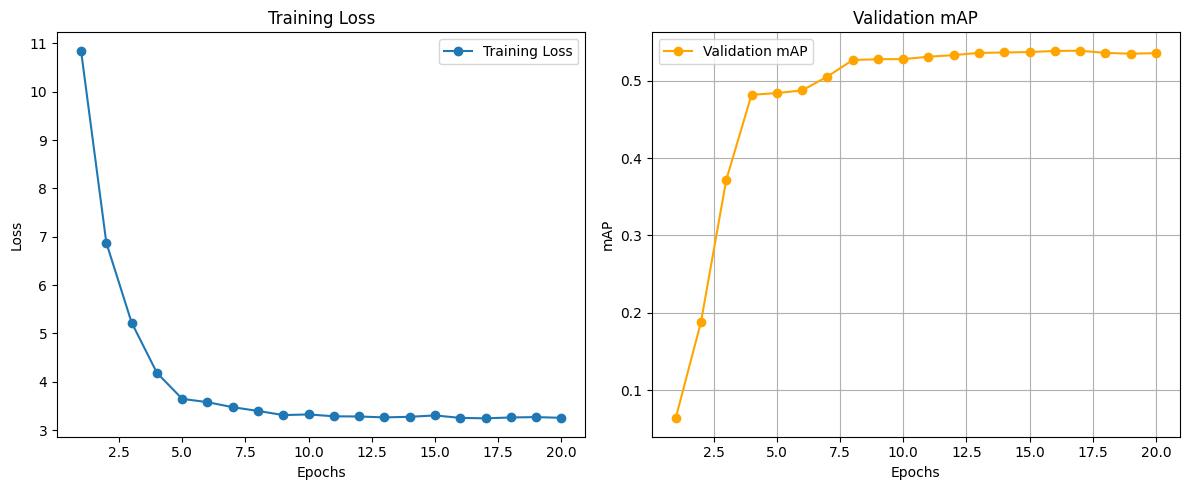

In [16]:
# Initialize the traffic sign detection model
detector = TrafficSignDetectorSSD(num_classes=5)  # 4 classes + background

# Train or load model
if os.path.exists(model_path):
    print(f"Loading the saved model from {model_path}...")
    detector.load_model(model_path)
else:
    print("No saved model found. Starting training...")
    os.makedirs('/content/drive/MyDrive/traffic_sign_models/', exist_ok=True)
    detector.train(train_loader, test_loader)




Analyzing performance vs IoU thresholds...
Evaluating for IoU threshold: 0.5
For IoU 0.5, mAP: 0.5355014204978943, mAP per class: [0.6791912913322449, 0.5977585315704346, 0.42457473278045654, 0.4404812157154083]
Evaluating for IoU threshold: 0.6
For IoU 0.6, mAP: 0.49786365032196045, mAP per class: [0.6138095855712891, 0.527965784072876, 0.42457473278045654, 0.425104558467865]
Evaluating for IoU threshold: 0.7
For IoU 0.7, mAP: 0.46316400170326233, mAP per class: [0.5229085087776184, 0.527965784072876, 0.42457473278045654, 0.3772070109844208]
Evaluating for IoU threshold: 0.8
For IoU 0.8, mAP: 0.311163067817688, mAP per class: [0.38422727584838867, 0.3541296422481537, 0.25808581709861755, 0.24820952117443085]
Evaluating for IoU threshold: 0.9
For IoU 0.9, mAP: 0.057360805571079254, mAP per class: [0.10727290064096451, 0.10031099617481232, 0.005657708737999201, 0.016201620921492577]
Category: prohibitory, IoU AP values: [0.6791912913322449, 0.6138095855712891, 0.5229085087776184, 0.384

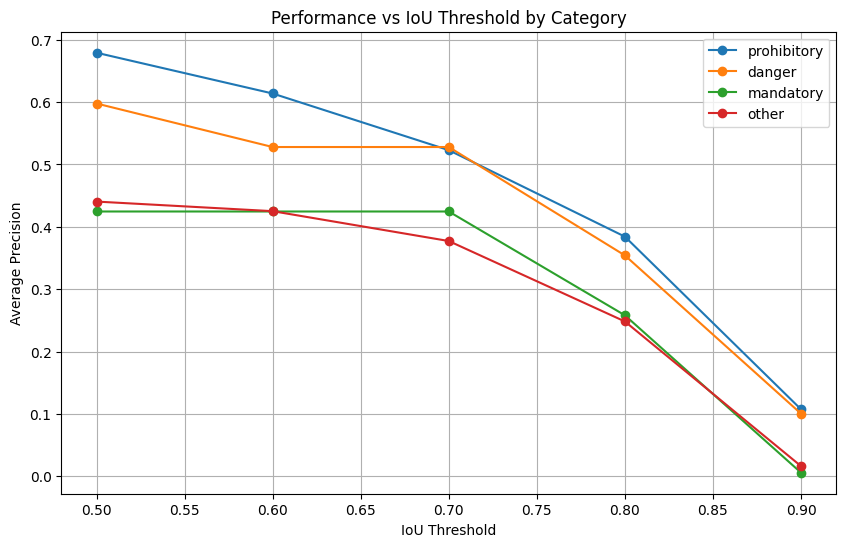

In [17]:
# Analyze performance over IoU thresholds
print("\nAnalyzing performance vs IoU thresholds...")
iou_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]

# Evaluate
results = detector.analyze_performance(test_loader)

# Visualize
plot_performance_curves(results, iou_thresholds)

Object counts per size category: {'small': 86, 'medium': 72, 'large': 86}


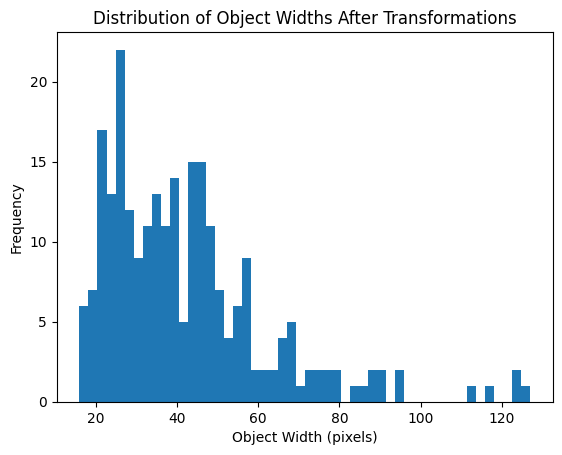

In [18]:
def analyze_object_sizes(data_loader):
    size_counts = {'small': 0, 'medium': 0, 'large': 0}
    all_widths = []

    for images, targets in data_loader:
        for target in targets:
            boxes = target['boxes']
            for box in boxes:
                width = box[2] - box[0]
                all_widths.append(width.item())
                category = categorize_object_size(width)
                size_counts[category] += 1

    print(f"Object counts per size category: {size_counts}")
    plt.hist(all_widths, bins=50)
    plt.xlabel('Object Width (pixels)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Object Widths After Transformations')
    plt.show()

analyze_object_sizes(test_loader)


Evaluating performance by object size...
Performance by object size: {'small': 0.08637011796236038, 'medium': 0.6201991438865662, 'large': 0.9586948156356812}


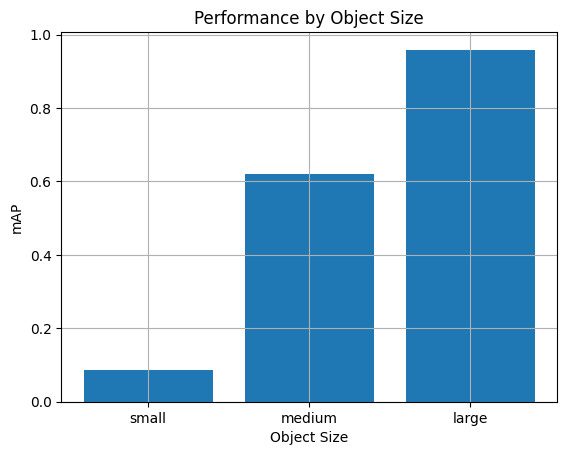

In [19]:
# Evaluate performance by object size
print("\nEvaluating performance by object size...")
size_thresholds = (32, 45)  # Adjust thresholds as needed
size_map = detector.evaluate_by_size(test_loader)
print(f"Performance by object size: {size_map}")
plot_size_accuracy(size_map)

In [20]:
def get_transforms(train):
    transforms = []
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    transforms.append(ToTensor())
    transforms.append(Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]))
    # Create a custom compose function that handles both image and target
    return Compose(transforms)  # Use custom Compose class

# Add this new Compose class
class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target


In [21]:
def visualize_results_with_ground_truth(model, image_path, annotations, device, conf_threshold=0.5):
    """
    Visualize both model predictions and ground truth annotations
    """
    # Define category mapping
    category_map = {
        1: 'prohibitory',
        2: 'danger',
        3: 'mandatory',
        4: 'other'
    }

    # Define colors for different purposes (BGR format for OpenCV)
    colors = {
        'prediction': (255, 0, 0),    # Red for predictions
        'ground_truth': (0, 255, 0),  # Green for ground truth
        'match': (0, 0, 255)          # Blue for matching predictions
    }

    # Load and prepare image
    image = Image.open(image_path).convert("RGB")

    # Create a dummy target
    dummy_target = {
        'boxes': torch.zeros((0, 4), dtype=torch.float32),
        'labels': torch.zeros(0, dtype=torch.int64),
        'image_id': torch.tensor([0])
    }

    # Apply transforms using the custom Compose
    transform = get_transforms(train=False)
    image_tensor, _ = transform(image, dummy_target)

    # Get model predictions
    model.eval()
    with torch.no_grad():
        prediction = model([image_tensor.to(device)])[0]

    # Convert image to numpy for drawing
    image_np = np.array(image)

    # Get ground truth annotations for this image
    image_name = os.path.basename(image_path)
    gt_boxes = annotations.get(image_name, [])

    # Draw ground truth boxes first
    for gt in gt_boxes:
        x1, y1, x2, y2 = gt['x1'], gt['y1'], gt['x2'], gt['y2']
        category = get_category(gt['class_id'])  # You'll need to implement this based on your mapping

        # Draw ground truth box in green
        cv2.rectangle(image_np, (x1, y1), (x2, y2), colors['ground_truth'], 2)

        # Add ground truth label
        gt_label = f"GT: {category}"
        cv2.putText(image_np, gt_label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, colors['ground_truth'], 2)

    # Draw prediction boxes
    for box, score, label in zip(prediction['boxes'], prediction['scores'], prediction['labels']):
        if score > conf_threshold:
            box = box.cpu().numpy()
            x1, y1, x2, y2 = map(int, box)
            predicted_category = category_map.get(label.item(), 'unknown')

            # Check if this prediction matches any ground truth box
            is_match = False
            for gt in gt_boxes:
                iou = calculate_iou(box, [gt['x1'], gt['y1'], gt['x2'], gt['y2']])
                if iou > 0.5:  # IOU threshold
                    is_match = True
                    break

            # Choose color based on whether it's a match
            color = colors['match'] if is_match else colors['prediction']

            # Draw prediction box
            cv2.rectangle(image_np, (x1, y1), (x2, y2), color, 2)

            # Add prediction label with confidence score
            pred_label = f"Pred: {predicted_category} ({score:.2f})"
            cv2.putText(image_np, pred_label, (x1, y2+20), cv2.FONT_HERSHEY_SIMPLEX,
                        0.5, color, 2)

    # Add legend
    legend_y = 30
    for key, color in colors.items():
        cv2.putText(image_np, key, (10, legend_y), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, color, 2)
        legend_y += 20

    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Traffic Sign Detection Results: {image_name}")
    plt.show()

def calculate_iou(box1, box2):
    """
    Calculate Intersection over Union between two bounding boxes
    """
    # Convert boxes to coordinates
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    # Calculate intersection coordinates
    x1_i = max(x1_1, x1_2)
    y1_i = max(y1_1, y1_2)
    x2_i = min(x2_1, x2_2)
    y2_i = min(y2_1, y2_2)

    # Calculate areas
    intersection_area = max(0, x2_i - x1_i) * max(0, y2_i - y1_i)
    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

def get_category(class_id):
    if class_id <= 5 or 7 <= class_id <= 10 or class_id in [15, 16]:
        return 'prohibitory'
    elif 18 <= class_id <= 31 or class_id == 11:
        return 'danger'
    elif 33 <= class_id <= 40:
        return 'mandatory'
    return 'other'


Visualizing sample predictions...


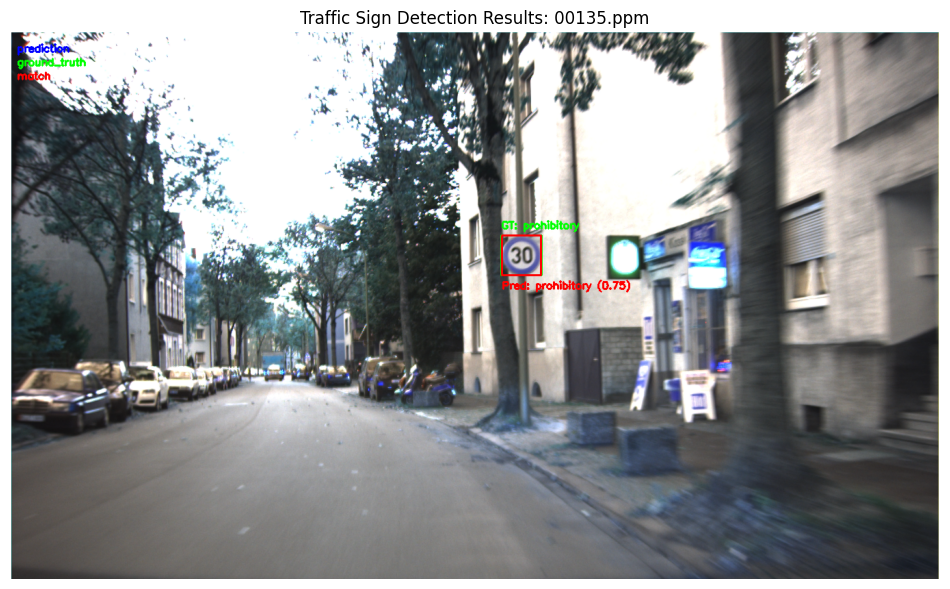


All tasks completed!


In [22]:
# Visualize a sample prediction
print("\nVisualizing sample predictions...")
image_path = os.path.join(image_dir, test_names[39])
visualize_results_with_ground_truth(
    model=detector.model,
    image_path=image_path,
    annotations=test_dataset.annotations,
    device=detector.device
)

print("\nAll tasks completed!")